## TASK#2 AB testing
Пришло время проанализировать результаты эксперимента, который мы провели вместе с командой дата сайентистов. Эксперимент проходил с 2023-07-30 по 2023-08-05 включительно. Для эксперимента были задействованы 2 и 1 группы. 

В группе 2 был использован один из новых алгоритмов рекомендации постов, группа 1 использовалась в качестве контроля. 

Основная гипотеза заключается в том, что новый алгоритм во 2-й группе приведет к увеличению CTR. 

Ваша задача — проанализировать данные А/B-теста. 

1. Выбрать метод анализа и сравнить CTR в двух группах (мы разбирали t-тест, Пуассоновский бутстреп, тест Манна-Уитни, t-тест на сглаженном ctr (α=5) а также t-тест и тест Манна-Уитни поверх бакетного преобразования).
2. Сравните данные этими тестами. А еще посмотрите на распределения глазами. Почему тесты сработали именно так? 
3. Опишите потенциальную ситуацию, когда такое изменение могло произойти. Тут нет идеального ответа, подумайте.
4. Напишите рекомендацию, будем ли мы раскатывать новый алгоритм на всех новых пользователей или все-таки не стоит.

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import pandahouse
import scipy.stats as stats

In [22]:
#читаем нашу бд

connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator'
}

q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM simulator_20230820.feed_actions 
WHERE toDate(time) between '2023-07-30' and '2023-08-05'
    and exp_group in (1,2)
GROUP BY exp_group, user_id
"""

df = pandahouse.read_clickhouse(q, connection=connection)

#дф который мы выгрузили
df.head()

,exp_group,user_id,likes,views,ctr
0,1,109963,3,15,0.200000
1,1,26117,32,141,0.226950
2,1,138232,18,73,0.246575
3,1,26295,39,141,0.276596
4,1,18392,7,32,0.218750


In [4]:
#проверяем что количество пользователей примерно одинаковое в группах 1 и 2 
df.groupby('exp_group').count()

,user_id,likes,views,ctr
exp_group,,,,
1,10020,10020,10020,10020
2,9877,9877,9877,9877


In [8]:
# проверяем средние - очень похожи 
df[df.exp_group == 1].ctr.mean(), df[df.exp_group == 2].ctr.mean()и

(0.216773994120072, 0.2161016893237817)

In [11]:
# проверяем медианы 
df[df.exp_group == 1].ctr.median(), df[df.exp_group == 2].ctr.median()

(0.2058823529411764, 0.1532846715328467)

<Axes: xlabel='ctr', ylabel='Count'>

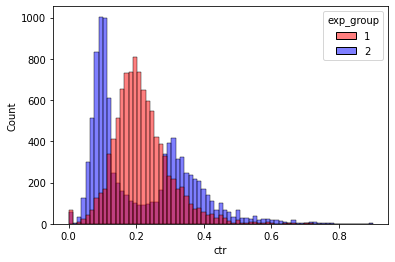

In [6]:
# Вот так наши группы выглядят на гистограмме

sns.histplot(data = df, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

Уже по гистограмме видно, что распределение групп не совпадает. Группа 2 (на которой тестировался новый алгоритм) имеет 2 моды. При этом, стал ли выше CTR во второй группе, непонятно.

<Axes: xlabel='exp_group', ylabel='ctr'>

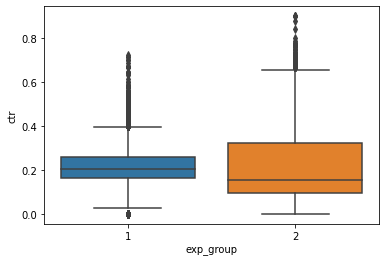

In [8]:
sns.boxplot(x = 'exp_group', y = 'ctr', data = df)

Нулевая гипотеза, которую мы будем проверять:
    Наш АБ тест не привел к существенным изменениям в CTR экспериментальной и контрольной групп, т.е.
<b> CTR группы 1 = CTR группы 2 </b>

### T-test

Так как распределение у группы 2 ненормальное и имеет много выбросов, применять Т-Тест и его вариации мы не можем.

### Mann-Whitney

In [23]:
mw_result = stats.mannwhitneyu(df[df.exp_group == 1].ctr, 
                   df[df.exp_group == 2].ctr,
                   alternative = 'two-sided')
mw_result

MannwhitneyuResult(statistic=55189913.0, pvalue=4.632205841806026e-45)

In [24]:
print(stats.mannwhitneyu(df[df.exp_group == 1].ctr,
                df[df.exp_group == 2].ctr))

A_gt_B = 0
for _ in range(10000):
    A_gt_B+= df[df.exp_group == 1].ctr.sample().values[0] > df[df.exp_group == 2].ctr.sample().values[0]
    
print('В', A_gt_B/100, '% случаев A > B. Должно получиться около 50%')

MannwhitneyuResult(statistic=55189913.0, pvalue=4.632205841806026e-45)
В 55.43 % случаев A > B. Должно получиться около 50%


### Bootstrap

In [12]:
def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):

    poisson_bootstraps1 = stats.poisson(1).rvs(
        (n_bootstrap, len(likes1))).astype(np.int64)

    poisson_bootstraps2 = stats.poisson(1).rvs(
            (n_bootstrap, len(likes2))).astype(np.int64)
    
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)

    return globalCTR1, globalCTR2


df = pandahouse.read_clickhouse(q, connection=connection)

likes1 = df[df.exp_group == 1].likes.to_numpy()
views1 = df[df.exp_group == 1].views.to_numpy()
likes2 = df[df.exp_group == 2].likes.to_numpy()
views2 = df[df.exp_group == 2].views.to_numpy()

ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)

<Axes: ylabel='Count'>

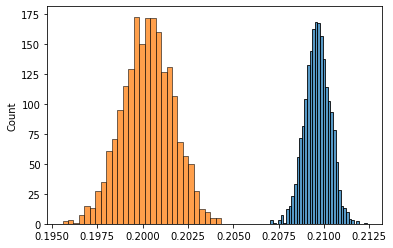

In [13]:
#  CTR по группам отдельно  - нет пересечения
sns.histplot(ctr1)
sns.histplot(ctr2)

<Axes: ylabel='Count'>

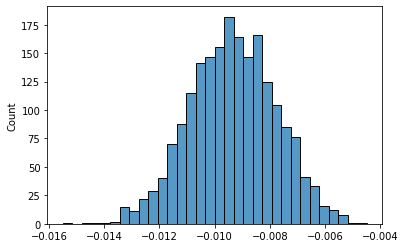

In [14]:
#Разница между глобальными CTR - 

sns.histplot(ctr2 - ctr1)


In [16]:
### Mann-Whitney with buckets

In [18]:
q = """

SELECT exp_group, bucket,
    sum(likes)/sum(views) as bucket_ctr
FROM (SELECT exp_group, 
        xxHash64(user_id)%50 as bucket,
        user_id,
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        likes/views as ctr
    FROM simulator_20230820.feed_actions 
    WHERE toDate(time) between '2023-07-30' and '2023-08-05'
        and exp_group in (1,2)
    GROUP BY exp_group, bucket, user_id)
GROUP BY exp_group, bucket
"""

df = pandahouse.read_clickhouse(q, connection=connection)

#тест Манна-Уитни видит отличие
stats.mannwhitneyu(df[df.exp_group == 1].bucket_ctr, 
                   df[df.exp_group == 2].bucket_ctr, 
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=1997.0, pvalue=2.6576427804010095e-07)

### Выводы
1. По итогам трех проведенных нами тестов (Бустрап, Манн-Уитни и Манн-Уитни с бакетным преобразованием) вы видим статистически значимые различия между двумя группами, и соотвественно можем отклонить нулевую гипотезу.
2. В принципе, различие между группами было видно уже на гистограмме - пользователи, на которых тестировали новый алгоритм, разделились на две подгруппы - в одной из них CTR вырос по сравнению с контрольным, в другой - наоборот, упал.
3. Почему так произошло?
* exp_group = 2 - Рекомендации "похожих на лайкнутые постов"
Можно предположить несколько вариантов, почему это могло не сработать у каких-то пользователей:
 - они не хотят лайкать одинаковые посты (я уже поставил лайк на такой же пост, зачем ставить еще и сюда)
 - они тратят больше времени на просмотр постов (меньше постов просмотрено в единицу времени - меньше лайков)
4. Будем ли мы раскатывать новый алгоритм?
Нет, несмотря на статистически значимое различие, среднее количество лайков не изменилось, а пользователей которые стали ставить меньше лайков, стало больше (медиана ниже в экспериментальной группе).
Нужно провести более глубокий анализ, чтобы понять причины разделения пользователей на дву подгруппы в экспериментальной группе. Возможно, подключить к анализу фактор времени (время на промотр поста, время онлайн)
